<a href="https://colab.research.google.com/github/AnastasiaDv491/AA-course-assignment2/blob/main/AA_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # mount google drive; use only if you have to access local files

Mounted at /content/gdrive


In [ ]:
# force remove a folder sample_data
!rm -rf sample_data

In [2]:
pip install progress progressbar2 alive-progress tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9630 sha256=29764a1fcf30783ef98bba606b87d5ca8abf19e3564c7f7043ccff8e34eecc0c
  Stored in directory: /root/.cache/pip/wheels/4c/9b/0a/a78ff56725af3ef70792f9ed0f8dbbc4c0315edc62cbc4a6b8
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210095 sha256=eb5fc7e47fa2c86421e8d29dac2b2850378eadc53c28d210d4fa141dde208627
  Stored in directory: /root/.cache/pip/wheels/91/a8/bc/5b55a10f763ee2c066ff2d94058d7dd64d570fc45adc027b3d
Successfully built progress grapheme


In [3]:
# Import libraries
import os
import random
from time import sleep
from progress.bar import Bar

import shutil  # For managing files and directories in a cross-platform manner
import keras  # For building deep learning models
import numpy as np  # For numerical operations on arrays
import glob  # For finding file paths
from tqdm import tqdm  # For progress bars

# Data preprocessing
from keras.preprocessing.image import ImageDataGenerator  # For image data augmentation

# Data visualization
import seaborn as sns  # For statistical visualizations
import plotly.graph_objs as go  # For interactive visualizations
import matplotlib.pyplot as plt  # For creating static plots

# Model architecture
from keras import Sequential  # For building sequential models
from keras.models import load_model  # For loading pre-trained models
from keras.layers import Dense, GlobalAvgPool2D as GAP, Dropout  # For defining model layers

# Training callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping  # For training callbacks

# Pre-trained models
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2  # For using pre-trained models

# AA project 2


In [4]:
!wget "http://seppe.net/aa/assignment2/images.zip" # load the data; takes a while

!unzip images.zip # unzip images file


Streaming output truncated to the last 5000 lines.
  inflating: images/748460.jpg       
  inflating: images/748461.jpg       
  inflating: images/748465.jpg       
  inflating: images/748467.jpg       
  inflating: images/748531.jpg       
  inflating: images/748532.jpg       
  inflating: images/748534.jpg       
  inflating: images/748535.jpg       
  inflating: images/748536.jpg       
 extracting: images/748537.jpg       
  inflating: images/748589.jpg       
  inflating: images/748591.jpg       
  inflating: images/748593.jpg       
  inflating: images/748663.jpg       
  inflating: images/748665.jpg       
  inflating: images/748666.jpg       
  inflating: images/748667.jpg       
  inflating: images/748727.jpg       
  inflating: images/748728.jpg       
  inflating: images/748729.jpg       
  inflating: images/748730.jpg       
  inflating: images/748733.jpg       
  inflating: images/748795.jpg       
  inflating: images/748798.jpg       
  inflating: images/748803.jpg       

In [5]:
# get a random sample of images for the model; of 20000
# resources to include in the report: random sample the data
# https://stackoverflow.com/questions/59068321/placing-randomly-selected-images-into-new-folder
to_be_moved = random.sample(glob.glob("./images/*.jpg"), 20000)

for f in enumerate(to_be_moved, 1):
    dest = "./images_sample"
    if not os.path.exists(dest):
        os.makedirs(dest)
    shutil.copy(f[1], dest)

!rm images.zip # remove the zip file
!rm -rf images # remove images folder

In [7]:
# check whether the image set contains any corrupt images and remove them
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("./images_sample").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
      os.remove(img_p)
      print(img_p)

In [8]:
# Option1: getting json data; upload your local json file to continue
# this takes some time
import json
from google.colab import files
uploaded = files.upload()


In [9]:
# Option2: load from the link
!gdown 11QCZxr4rXNk6kzJk4X4P_H8PnyarG7fJ

Downloading...
From: https://drive.google.com/uc?id=11QCZxr4rXNk6kzJk4X4P_H8PnyarG7fJ
To: /content/dataset.json
100% 108M/108M [00:01<00:00, 63.6MB/s]


In [10]:
# Loading json file and reading it
json_file = open('dataset.json')
json_data = json.load(json_file)

In [11]:
non_price_category_data = []

# Remove all restaurant data where there is no price_category. 
# Restaurant with no price category are stored in non_price_category_data array
# [:] makes shallow copy from the data so that we can remove the data from the original array
for restaurant in json_data[:]:
  if restaurant['price_category'] == None:
    non_price_category_data.append(restaurant)
    json_data.remove(restaurant)

In [12]:
unique_label_slugs = []

# Get the unique slugs for price_category from the selected JSON data
for restaurant in json_data:
  if restaurant['price_category']['slug'] not in unique_label_slugs:
    unique_label_slugs.append(restaurant['price_category']['slug'])

unique_label_slugs

['mid-range', 'premium', 'luxury', 'affordable']

In [17]:
debug_flag = False

import shutil 
import os

# creating sub-folders per label
for slug in unique_label_slugs:
  path = os.path.join('data',slug)
  if not os.path.exists(path):
    os.makedirs(path)

path = ""

for restaurant in json_data:
  for image in restaurant["more_details"]["full_images"]:
    if debug_flag:
      print(image["image_id"])
    basepath = os.path.join('data',restaurant["price_category"]["slug"])
    filename = image["image_id"]+".jpg"
    dest_path = os.path.join(basepath,filename)
    if os.path.isfile(dest_path):
      if debug_flag:
        print("File exists")
    else:
      source_path = os.path.join("images_sample",filename)
      if os.path.isfile(source_path):
        shutil.copyfile(source_path, dest_path)
      else:
        if debug_flag:
          print("File doesn't exist in base data")
  

In [ ]:
shutil.rmtree("data/.ipynb_checkpoints") # removes the hidden directory that messes with classes later on
os.listdir("data")


In [19]:
path = './data'

class_sizes = []
for name in unique_label_slugs:
    class_size = len(os.listdir(path+ "/" + name))
    class_sizes.append(class_size)
    
# Print the class distribution
print("Class Distribution:\n", class_sizes)

Class Distribution:
 [8179, 6256, 3835, 1484]


In [20]:
class_name_size = dict(zip(unique_label_slugs, class_sizes))
class_name_size

{'mid-range': 8179, 'premium': 6256, 'luxury': 3835, 'affordable': 1484}

In [25]:
# Data preprocessing
data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20,
    validation_split=0.2
)

In [26]:
path = './data'
train_data = data_generator.flow_from_directory(
    path,
    target_size =(256,256),
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)

valid_data = data_generator.flow_from_directory(
    path, 
    target_size=(256,256), 
    class_mode='binary', 
    batch_size=32, 
    shuffle=True, 
    subset='validation')

Found 15805 images belonging to 4 classes.
Found 3949 images belonging to 4 classes.


(32, 256, 256, 3)


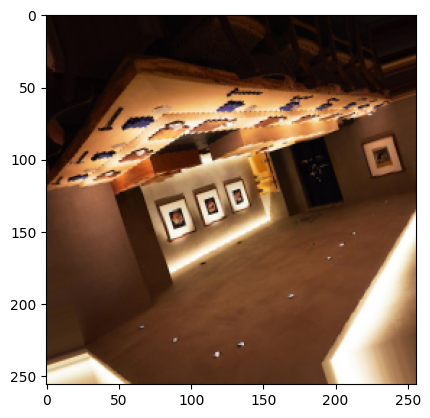

(32, 256, 256, 3)


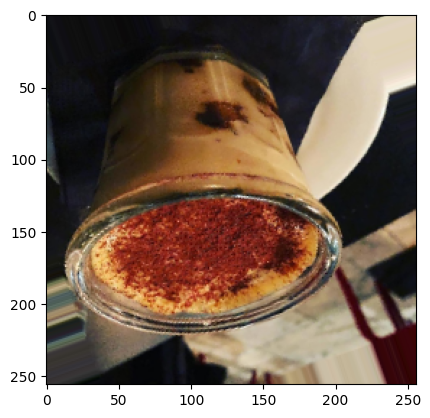

(32, 256, 256, 3)


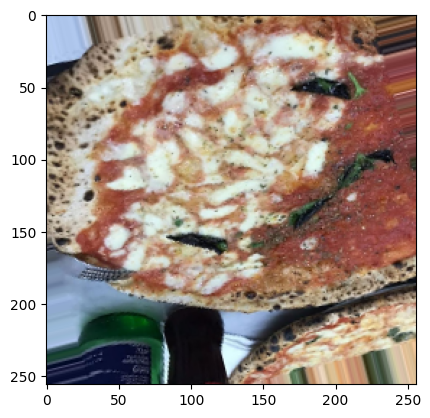

(32, 256, 256, 3)


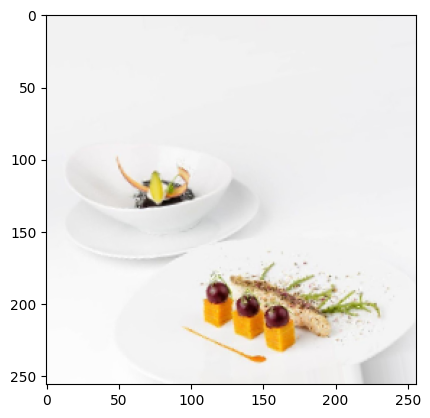

(32, 256, 256, 3)


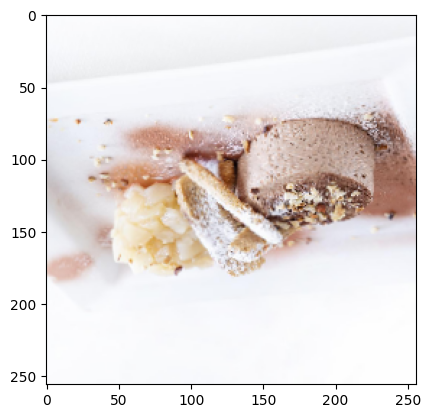

In [27]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/63355107/keras-imagedatagenerator-result-display-flow
for _ in range(5):
    img, label = train_data.next()
    print(img.shape)   #  (32,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [ ]:
# used as a test to see if the data is run correctly
name = "ResNet152V2"
base_model = ResNet152V2(include_top=False, input_shape=(256,256,3), weights='imagenet') # freezing
base_model.trainable = False

# resnet = Sequential([
#     base_model,
#     GAP(),
#     Dense(256, activation = "relu"),
#     Dropout(0.2),
#     Dense(10, activation = "softmax")
# ], name = name)

resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

resnet.fit(
    train_data, validation_data=valid_data,
    epochs=10, callbacks=cbs
)


In [ ]:
model_file_path = 'ResNet152V2.h5'
loaded_model = load_model(model_file_path)
loaded_model.summary()

loaded_model.evaluate(valid_data)